# [★★★★★] Integrating Preprocessing with Python

Minimum version: v2.5

In this example, we demonstrate how to use python to preprocess data by creating a frame structure. This example requires some Python familiarity. However, as we are developing a frame structure which contains mainly frame elements, the procedure is relatively straightforward.

## Objective

We are going to create a three--storey frame as shown below.

![three storey frame](three-storey-frame.svg)

## Prerequisites

We are going to find section properties from AISC table, which is available online.

In [1]:
import pandas

section_table = pandas.read_excel(
    'https://www.aisc.org/globalassets/aisc/manual/v15.0-shapes-database/aisc-shapes-database-v15.0.xlsx',
    sheet_name=1,
    usecols='A:CF')
print(section_table.head())

Database v15.0
  Type EDI_Std_Nomenclature AISC_Manual_Label T_F      W      A     d    ddet  \
0    W              W44X335           W44X335   F  335.0   98.5    44      44   
1    W              W44X290           W44X290   F  290.0   85.4  43.6  43.625   
2    W              W44X262           W44X262   F  262.0   77.2  43.3   43.25   
3    W              W44X230           W44X230   F  230.0   67.8  42.9  42.875   
4    W              W40X655           W40X655   T  655.0  193.0  43.6  43.625   

  Ht  h  ...   rts    ho   PA PA2   PB   PC   PD   T  WGi WGo  
0  –  –  ...  4.24  42.2  132   –  148  104  120  38  5.5   –  
1  –  –  ...   4.2    42  131   –  147  103  119  38  5.5   –  
2  –  –  ...  4.17  41.9  131   –  147  102  118  38  5.5   –  
3  –  –  ...  4.13  41.7  130   –  146  102  118  38  5.5   –  
4  –  –  ...  4.71  40.1  132   –  149  104  121  34  7.5   –  

[5 rows x 84 columns]


Section properties such as area and moment of inertia can be extracted from this table using section designations. It is possible to define such a function now.

In [2]:
def from_table(designation: str):
    index = section_table.index[section_table['AISC_Manual_Label'] == designation].tolist()
    assert len(index) == 1
    a = section_table.at[index[0], 'A']  # area
    sx = section_table.at[index[0], 'Sx']  # elastic modulus
    ix = section_table.at[index[0], 'Ix']  # moment of inertia
    zx = section_table.at[index[0], 'Zx']  # plastic modulus
    return a, sx, ix, zx

Then we can use this function to extract section properties from the table. For example,

In [3]:
print(from_table('W44X230'))

(67.8, 971.0, 20800.0, 1100.0)


## Geometry of the Frame Structure

For simplicity, we assume the frame structure has the same column/beam section for all the columns/beams on the same floor. Under such a condition, two lists of section designations can be provided so that elements can be created. Similarly, geometry information such as floor height, bay span, as well as floor mass, can be provided in the same way.

For example, we can define several lists as follows.

In [4]:
girder = ['W21X68', 'W21X68', 'W21X68']  # floor 1 2 3
column = ['W14X193', 'W14X159', 'W14X159']  # column 1 2 3
mass = [10., 10., 10.]  # floor 1 2 3
span = [240., 240.]  # bay span 1 2
height = [120., 120., 120.]  # floor height 1 2 3

### Generate Node Grid

Given that span and height are given, it is possible to calculate the absolute position of the nodes.

In [5]:
import numpy as np

x_coor = np.cumsum(span)
y_coor = np.cumsum(height)
x_coor = np.insert(x_coor, 0, 0.)
y_coor = np.insert(y_coor, 0, 0.)
print(x_coor, y_coor)

del span, height

[  0. 240. 480.] [  0. 120. 240. 360.]


By using the above coordinates, we can create a grid of nodes. A simple `Node` class is defined to represent nodes.

In [6]:
from dataclasses import dataclass


@dataclass
class Node:
    tag: int
    x: float
    y: float

    def write_to(self, f_handler):
        f_handler.write(f'node {self.tag} {self.x:.2f} {self.y:.2f}\n')


node_pool: dict = {}

node_grid = np.zeros((len(y_coor), len(x_coor))).astype(int)

node_tag = 1
with open('node.sp', 'w') as f:
    for i in range(len(x_coor)):
        for j in range(len(y_coor)):
            node = Node(node_tag, x_coor[i], y_coor[j])
            node.write_to(f)
            node_pool[node_tag] = node
            node_grid[j, i] = node_tag
            node_tag += 1
del node_tag

with open('node.sp', 'r') as f:
    print(f.read())

node 1 0.00 0.00
node 2 0.00 120.00
node 3 0.00 240.00
node 4 0.00 360.00
node 5 240.00 0.00
node 6 240.00 120.00
node 7 240.00 240.00
node 8 240.00 360.00
node 9 480.00 0.00
node 10 480.00 120.00
node 11 480.00 240.00
node 12 480.00 360.00



The `node_grid` can be used to generate elements.

### Generate Beam Elements

Starting with the second row, beam elements can be generated by looping over each row.

In [7]:
from math import sqrt

e = 29  # mpsi, Young's modulus
fy = .05  # mpsi, yield stress
hardening = .01  # isotropic hardening ratio
nm_size = 1.15  # initial surface size

section_pool: dict = {}
element_pool: dict = {}


@dataclass
class Section:
    tag: int
    name: str
    fp: float
    mp: float
    ea: float
    ei: float
    mult: float

    def __init__(self, tag, name):
        self.tag = tag
        self.name = name
        _a, _sx, _ix, _zx = from_table(name)
        self.fp = fy * _a
        self.mp = fy * _sx
        self.ea = e * _a
        self.ei = e * _ix
        self.mult = fy * _zx

    def write_to(self, f_handler, d, h):
        f_handler.write(
            f'section NM2D3 {self.tag} {self.ea:.4e} {self.ei:.4e} '  # basic section properties
            f'{self.fp:.4e} {self.mp:.4e} {d} '  # yield forces
            f'{h} 0. 0. {self.mult / self.mp - 1:.4f} 1. '  # hardening configurations
            f'0.\n')  # linear density


@dataclass
class Element:
    tag: int
    node_i: Node
    node_j: Node
    section: Section
    element_length: float

    def __init__(self, tag, _node_i, _node_j, _section):
        self.tag = tag
        self.node_i = _node_i
        self.node_j = _node_j
        self.section = _section
        self.element_length = sqrt((_node_i.x - _node_j.x) ** 2 + (_node_i.y - _node_j.y) ** 2)

    def write_to(self, f_handler):
        f_handler.write(f'element NMB21 {self.tag} {self.node_i.tag} {self.node_j.tag} {self.section.tag}\n')


element_tag = 1
section_tag = 1
with open('beam.sp', 'w') as f:
    for i in range(1, len(y_coor)):
        section = Section(section_tag, girder[i - 1])
        section.write_to(f, nm_size, hardening)
        section_pool[section_tag] = section
        for j in range(len(x_coor) - 1):
            node_i = node_grid[i, j]
            node_j = node_grid[i, j + 1]
            element = Element(element_tag, node_pool[node_i], node_pool[node_j], section)
            element.write_to(f)
            element_pool[element_tag] = element
            element_tag += 1
        section_tag += 1

with open('beam.sp', 'r') as f:
    print(f.read())

section NM2D3 1 5.8000e+02 4.2920e+04 1.0000e+00 7.0000e+00 1.15 0.01 0. 0. 0.1429 1. 0.
element NMB21 1 2 6 1
element NMB21 2 6 10 1
section NM2D3 2 5.8000e+02 4.2920e+04 1.0000e+00 7.0000e+00 1.15 0.01 0. 0. 0.1429 1. 0.
element NMB21 3 3 7 2
element NMB21 4 7 11 2
section NM2D3 3 5.8000e+02 4.2920e+04 1.0000e+00 7.0000e+00 1.15 0.01 0. 0. 0.1429 1. 0.
element NMB21 5 4 8 3
element NMB21 6 8 12 3



### Generate Column Elements

Similarly, column elements can be generated by looping over each column.

In [8]:
with open('column.sp', 'w') as f:
    for i in range(len(y_coor) - 1):
        section = Section(section_tag, column[i])
        section.write_to(f, nm_size, hardening)
        section_pool[section_tag] = section
        for j in range(len(x_coor)):
            node_i = node_grid[i, j]
            node_j = node_grid[i + 1, j]
            element = Element(element_tag, node_pool[node_i], node_pool[node_j], section)
            element.write_to(f)
            element_pool[element_tag] = element
            element_tag += 1
        section_tag += 1

with open('column.sp', 'r') as f:
    print(f.read())

section NM2D3 4 1.6472e+03 6.9600e+04 2.8400e+00 1.5500e+01 1.15 0.01 0. 0. 0.1452 1. 0.
element NMB21 7 1 2 4
element NMB21 8 5 6 4
element NMB21 9 9 10 4
section NM2D3 5 1.3543e+03 5.5100e+04 2.3350e+00 1.2700e+01 1.15 0.01 0. 0. 0.1299 1. 0.
element NMB21 10 2 3 5
element NMB21 11 6 7 5
element NMB21 12 10 11 5
section NM2D3 6 1.3543e+03 5.5100e+04 2.3350e+00 1.2700e+01 1.15 0.01 0. 0. 0.1299 1. 0.
element NMB21 13 3 4 6
element NMB21 14 7 8 6
element NMB21 15 11 12 6



### Fibre Based Elements

The similar procedure can be used to generate fibre based elements with slight modifications. Here we use [`F21`](../../../Library/Element/Beam/F21.md) element. It relies on sections, and designations can be directly used to create sections. In this example, we use [`US2D`](../../../Library/Section/Code/US.md) category.

In [9]:
with open('fibre_frame.sp', 'w') as f:
    f.write(f'material Bilinear1D 1 {e} {fy} {hardening}\n\n')
    for v in section_pool.values():
        f.write(f'section US2D {v.name} {v.tag} 1\n')
    f.write('\n')
    for v in element_pool.values():
        f.write(f'element F21 {v.tag} {v.node_i.tag} {v.node_j.tag} {v.section.tag}\n')

with open('fibre_frame.sp', 'r') as f:
    print(f.read())

material Bilinear1D 1 29 0.05 0.01

section US2D W21X68 1 1
section US2D W21X68 2 1
section US2D W21X68 3 1
section US2D W14X193 4 1
section US2D W14X159 5 1
section US2D W14X159 6 1

element F21 1 2 6 1
element F21 2 6 10 1
element F21 3 3 7 2
element F21 4 7 11 2
element F21 5 4 8 3
element F21 6 8 12 3
element F21 7 1 2 4
element F21 8 5 6 4
element F21 9 9 10 4
element F21 10 2 3 5
element F21 11 6 7 5
element F21 12 10 11 5
element F21 13 3 4 6
element F21 14 7 8 6
element F21 15 11 12 6



### Generate Mass

For simplicity, we only apply horizontal mass to each node, the procedure is similar to that of frame elements.

To keep code modular, we define a mass grid to store mass at each node.

In [10]:
column_num = len(x_coor)
if 1 == column:
    portions = 1.
else:
    portions = 2. * (column_num - 1)

# unit conversion
portions *= 12 * 1000

# calculate tributary mass by assuming uniform density
# thus exterior nodes take half of the mass of interior nodes
mass_grid = np.zeros((len(y_coor), column_num))
for i in range(1, len(y_coor)):
    for j in range(column_num):
        mass_grid[i, j] = mass[i - 1] / portions
    for j in range(1, column_num - 1):
        mass_grid[i, j] *= 2.

print(mass_grid)

del column_num, portions

[[0.         0.         0.        ]
 [0.00020833 0.00041667 0.00020833]
 [0.00020833 0.00041667 0.00020833]
 [0.00020833 0.00041667 0.00020833]]


Now we assign mass to each node.

In [11]:
with open('mass.sp', 'w') as f:
    for node_tag, mass in zip(node_grid.flatten(), mass_grid.flatten()):
        if mass == 0.:
            continue
        f.write(f'element Mass {element_tag} {node_tag} {mass :.4e} 1 2\n')
        element_tag += 1

with open('mass.sp', 'r') as f:
    print(f.read())

element Mass 16 2 2.0833e-04 1 2
element Mass 17 6 4.1667e-04 1 2
element Mass 18 10 2.0833e-04 1 2
element Mass 19 3 2.0833e-04 1 2
element Mass 20 7 4.1667e-04 1 2
element Mass 21 11 2.0833e-04 1 2
element Mass 22 4 2.0833e-04 1 2
element Mass 23 8 4.1667e-04 1 2
element Mass 24 12 2.0833e-04 1 2



## Analysis Settings

The basic geometry of the model is defined in `node.sp`, `beam.sp`, `column.sp` and `mass.sp`. We import those files in the main script.

In [12]:
file_list = ['node.sp', 'beam.sp', 'column.sp', 'mass.sp']

main_file = open('three-storey-frame.sp', 'w')

for file in file_list:
    main_file.write(f'file {file}\n')

The boundary conditions can be assigned by simply fixing all bottom nodes.

In [13]:
main_file.write(f'fix 1 P 1 {" ".join(str(tag) for tag in node_grid[0, :])}\n')

pass

The ground motion shall be applied. The `ELNS` file contains one of the accelerograms of the 1940 El Centro Earthquake. It is normalised so that the maximum amplitude is unity, we assign a PGA of $$0.5g$$.

In [14]:
pga = .5
main_file.write(f'\namplitude Tabular 1 ELNS\n')
# 1 g = 386.0885826772 in/s2
main_file.write(f'\nacceleration 1 1 {386.0885826772 * pga:.5e} 1\n')

pass

For results, we can, for example, record the nodal displacement history.

In [15]:
recorder_tag = 1
main_file.write(f'\nhdf5recorder {recorder_tag} Node U ' + ' '.join([str(tag) for tag in node_pool.keys()]) + '\n')

pass

For illustration, we can also record element yield flag at both ends so that the corresponding plastic hinge distribution can be generated. The yield flag is **not** generally available in other elements.

In [16]:
recorder_tag += 1
main_file.write(
    f'\nhdf5recorder {recorder_tag} Element YF ' + ' '.join([str(tag) for tag in element_pool.keys()]) + '\n')

pass

We keep writing dynamic analysis step and the corresponding settings into the file.

In [17]:
# dynamic step
duration = 40.
time_step = 1E-2
main_file.write(f'\nstep dynamic 1 {duration:.3e}\n')
main_file.write(f'set ini_step_size {time_step:.2e}\n')
main_file.write('set fixed_step_size true\n')
main_file.write('set sparse_mat true\n')
main_file.write('set system_solver SuperLU\n\n')

main_file.write('converger AbsIncreDisp 1 1E-10 10 true\n\n')

# damping model
main_file.write('integrator LeeNewmarkFull 1 .25 .5 \\\n'
                '-type0 2.66040e-02 1.87264e-01 \\\n'
                '-type0 2.66170e-02 5.30209e+00 \\\n'
                '-type0 2.66310e-02 2.82431e+01 \\\n'
                '-type0 2.70320e-02 1.51584e+02 \\\n'
                '-type0 2.65990e-02 9.96227e-01 \\\n'
                '-type0 3.90780e-02 1.00100e-03 \\\n'
                '-type0 2.70050e-02 6.56300e-03 \\\n'
                '-type0 2.66190e-02 3.51830e-02 \\\n'
                '-type0 3.91040e-02 9.95802e+02\n')

main_file.write('\nanalyze\n')
main_file.write(f'\nsave recorder {" ".join([str(tag + 1) for tag in range(recorder_tag)])}\n')
main_file.write('\nexit\n')

pass

Do not forget to close the main file.

In [18]:
main_file.close()

with open('three-storey-frame.sp', 'r') as f:
    print(f.read())

file node.sp
file beam.sp
file column.sp
file mass.sp
fix 1 P 1 1 5 9

amplitude Tabular 1 ELNS

acceleration 1 1 1.93044e+02 1

hdf5recorder 1 Node U 1 2 3 4 5 6 7 8 9 10 11 12

hdf5recorder 2 Element YF 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

step dynamic 1 4.000e+01
set ini_step_size 1.00e-02
set fixed_step_size true
set sparse_mat true
set system_solver SuperLU

converger AbsIncreDisp 1 1E-10 10 true

integrator LeeNewmarkFull 1 .25 .5 \
-type0 2.66040e-02 1.87264e-01 \
-type0 2.66170e-02 5.30209e+00 \
-type0 2.66310e-02 2.82431e+01 \
-type0 2.70320e-02 1.51584e+02 \
-type0 2.65990e-02 9.96227e-01 \
-type0 3.90780e-02 1.00100e-03 \
-type0 2.70050e-02 6.56300e-03 \
-type0 2.66190e-02 3.51830e-02 \
-type0 3.91040e-02 9.95802e+02

analyze

save recorder 1 2

exit



Finally, let's pack everything into an archive so that it can be [downloaded](three-storey-frame.zip).

In [19]:
import os
from zipfile import ZipFile

file_list.append('fibre_frame.sp')
file_list.append('three-storey-frame.sp')
file_list.append('ELNS')

with ZipFile('three-storey-frame.zip', 'w') as f:
    for file in file_list:
        f.write(file)

## Run Analysis

The analysis can be run by calling the executable.

The online documentation is not calling the executable, but it is possible to run the analysis locally with the application available.

In [20]:
from shutil import which


def run_analysis():
    if os.name == 'nt':
        exe_name = 'suanPan.exe'
    else:
        exe_name = 'suanpan'

    if which(exe_name):
        os.system(f'{exe_name} -np -f three-storey-frame.sp')


run_analysis()

## Roof Displacement History

The result file will be generated and stored in `.h5` file. We can read the file and plot the results.

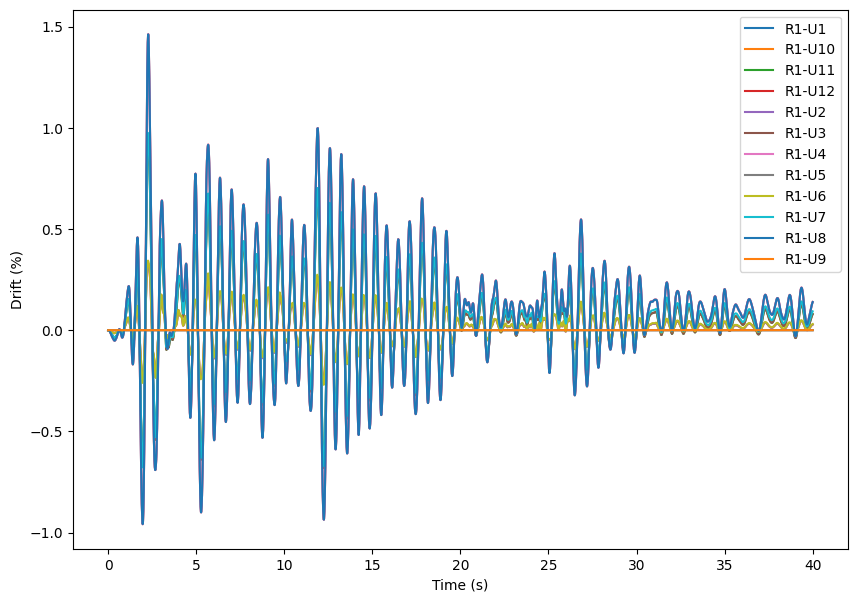

In [21]:
import h5py
import matplotlib.pyplot as plt
import glob


def plot_result():
    h5_file = glob.glob('*U.h5')
    if len(h5_file) == 0:
        return

    plt.figure(figsize=(10, 7))
    with h5py.File(h5_file[0], 'r') as result_file:
        for group in result_file.values():
            for key, data in group.items():
                plt.plot(data[:, 0], data[:, 1] / max(y_coor) * 100., label=key)
    plt.xlabel('Time (s)')
    plt.ylabel('Drift (%)')
    plt.legend()
    plt.show()


plot_result()

Clean up the files to end this example.

In [22]:
for file in file_list:
    if file == 'ELNS':
        continue
    if os.path.exists(file):
        os.remove(file)

Let's create some TikZ commands to be used to plot plastic hinge distribution.

In [23]:
tikz: list = []

# generate coordinates to represent nodal positions
for node in node_pool.values():
    tikz.append(f'\\coordinate(N{node.tag})at({node.x / 1E2},{node.y / 1E2});')

# draw frame elements
for element in element_pool.values():
    node_i = element.node_i
    node_j = element.node_j
    if node_i.x == node_j.x:
        # vertical columns
        tikz.append(
            f'\\draw[line width=1mm](N{element.node_i.tag})--(N{element.node_j.tag})node[midway,fill=white,font=\\tiny,rotate=90]{{{element.section.name}}};')
    else:
        # horizontal beams
        tikz.append(
            f'\\draw[line width=1mm](N{element.node_i.tag})--(N{element.node_j.tag})node[midway,fill=white,font=\\tiny]{{{element.section.name}}};')

hinge_label = '[fill=red,circle,draw,inner sep=0,minimum size=3mm]'

h5_file = glob.glob('*YF.h5')
if len(h5_file) > 0:
    with h5py.File(h5_file[0], 'r') as h_file:
        h5_prefix = h5_file[0].split('.')[0]
        for g in h_file.values():
            for k, v in g.items():
                element_tag = int(k.replace(h5_prefix, ''))
                node_i = element_pool[element_tag].node_i.tag
                node_j = element_pool[element_tag].node_j.tag

                if v[:, 1].max() > .5:
                    tikz.append(f'\\node{hinge_label}at($(N{node_i})!.1!(N{node_j})$){{}};')
                if v[:, 2].max() > .5:
                    tikz.append(f'\\node{hinge_label}at($(N{node_i})!.9!(N{node_j})$){{}};')

with open(f'DIST.tex', 'w') as f:
    f.write('\\begin{tikzpicture}[scale=2]\n')
    f.write('\n'.join(tikz))
    f.write('\n\\end{tikzpicture}\n')

with open(f'DIST.tex', 'r') as f:
    print(f.read())

\begin{tikzpicture}[scale=2]
\coordinate(N1)at(0.0,0.0);
\coordinate(N2)at(0.0,1.2);
\coordinate(N3)at(0.0,2.4);
\coordinate(N4)at(0.0,3.6);
\coordinate(N5)at(2.4,0.0);
\coordinate(N6)at(2.4,1.2);
\coordinate(N7)at(2.4,2.4);
\coordinate(N8)at(2.4,3.6);
\coordinate(N9)at(4.8,0.0);
\coordinate(N10)at(4.8,1.2);
\coordinate(N11)at(4.8,2.4);
\coordinate(N12)at(4.8,3.6);
\draw[line width=1mm](N2)--(N6)node[midway,fill=white,font=\tiny]{W21X68};
\draw[line width=1mm](N6)--(N10)node[midway,fill=white,font=\tiny]{W21X68};
\draw[line width=1mm](N3)--(N7)node[midway,fill=white,font=\tiny]{W21X68};
\draw[line width=1mm](N7)--(N11)node[midway,fill=white,font=\tiny]{W21X68};
\draw[line width=1mm](N4)--(N8)node[midway,fill=white,font=\tiny]{W21X68};
\draw[line width=1mm](N8)--(N12)node[midway,fill=white,font=\tiny]{W21X68};
\draw[line width=1mm](N1)--(N2)node[midway,fill=white,font=\tiny,rotate=90]{W14X193};
\draw[line width=1mm](N5)--(N6)node[midway,fill=white,font=\tiny,rotate=90]{W14X193};
\draw[l